In [138]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

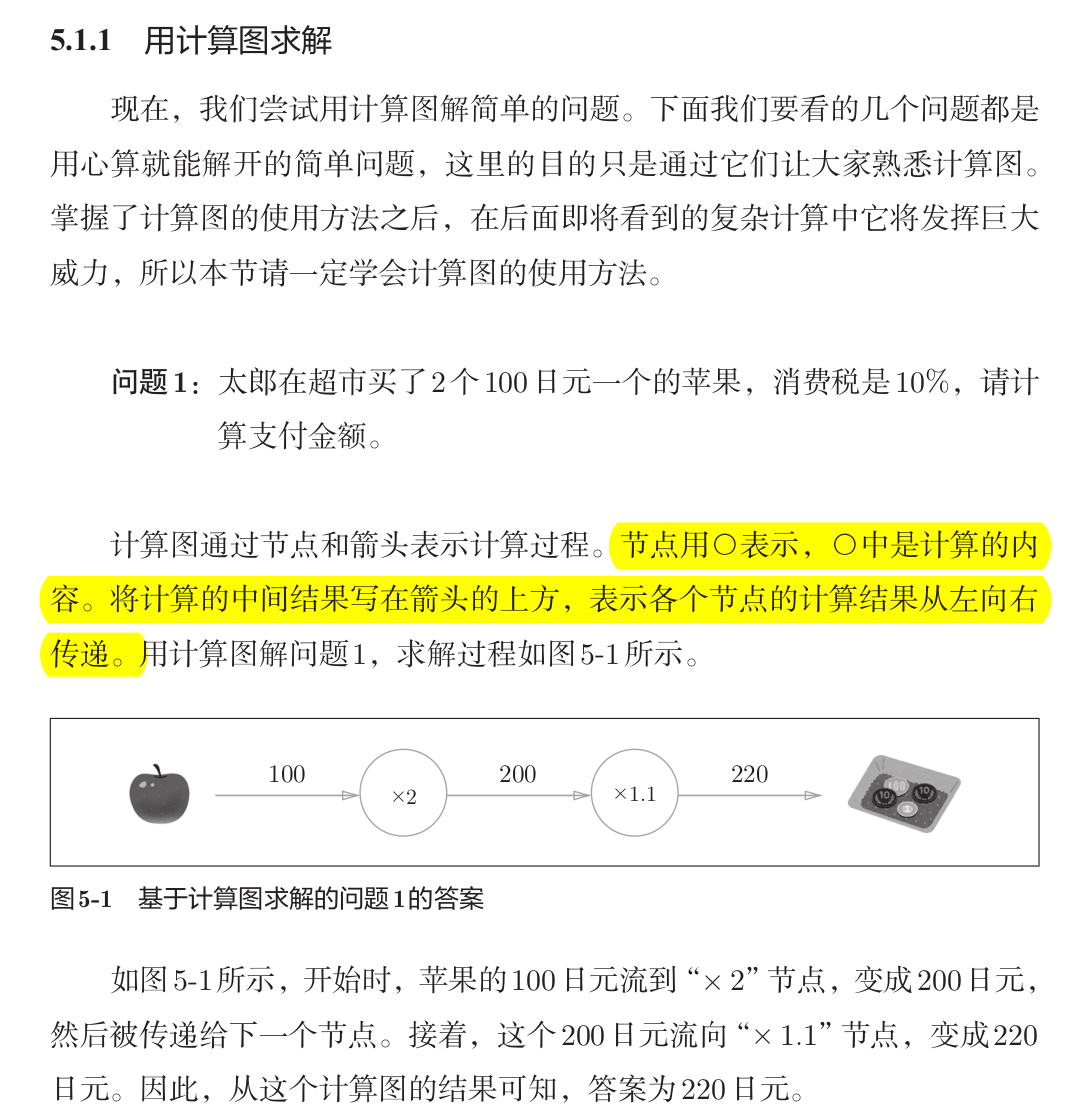


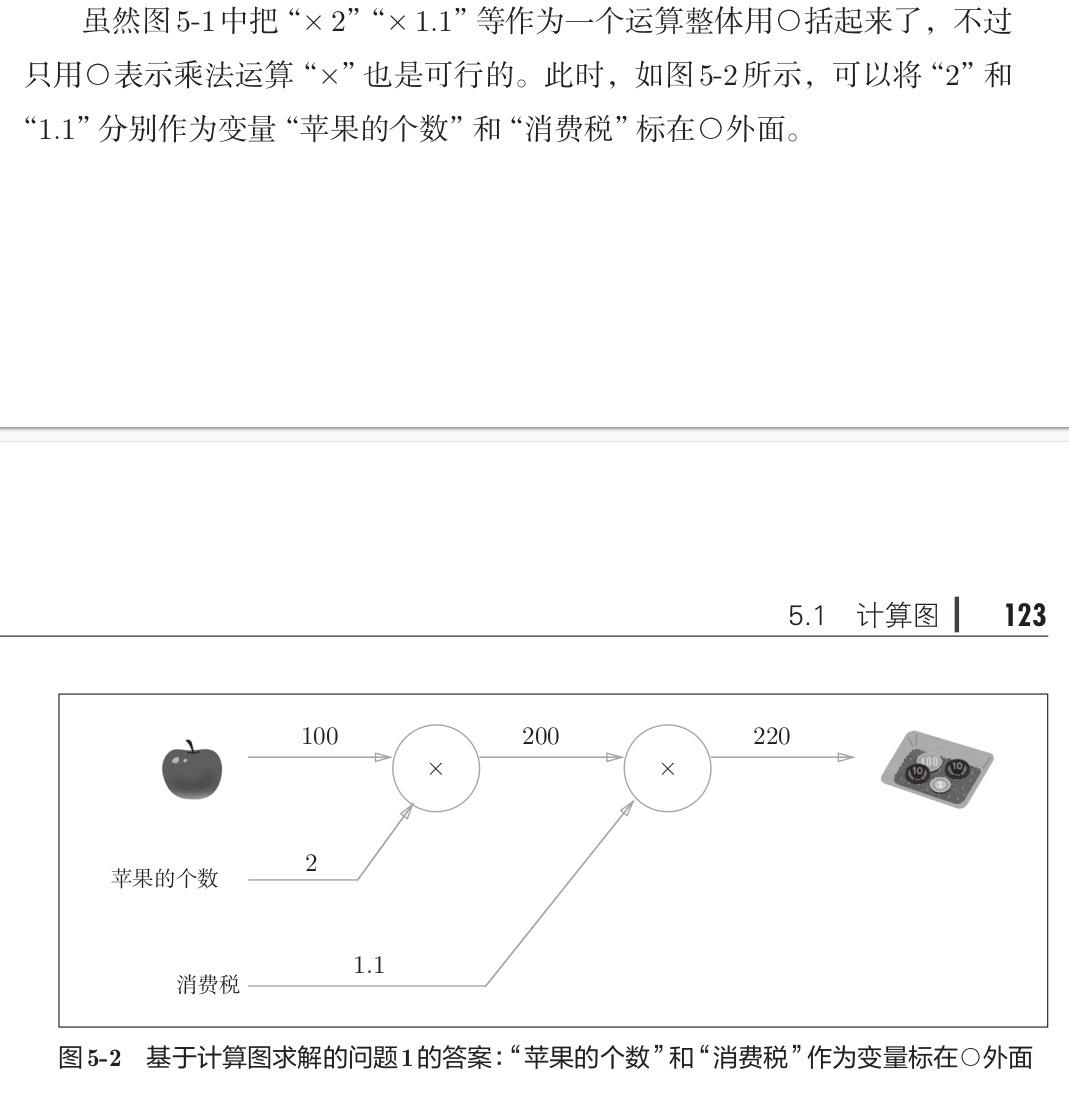
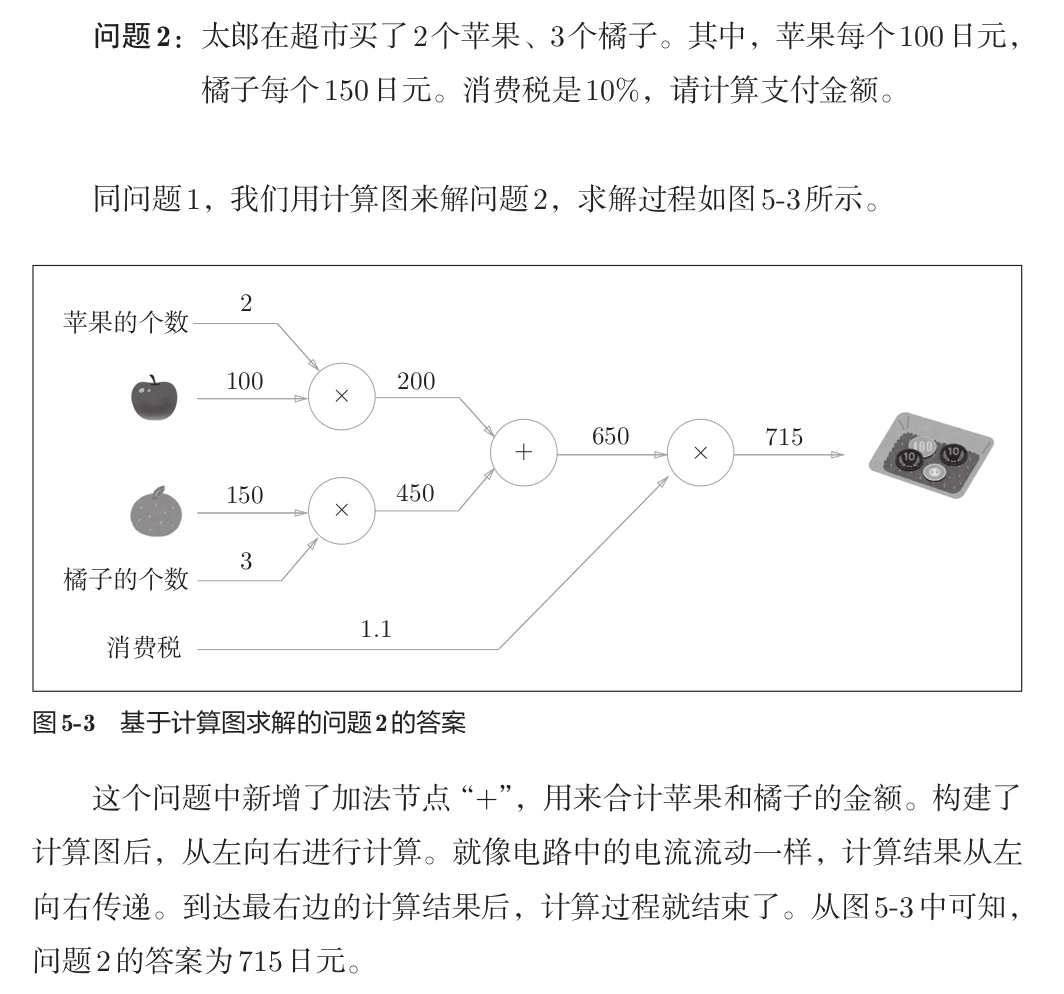

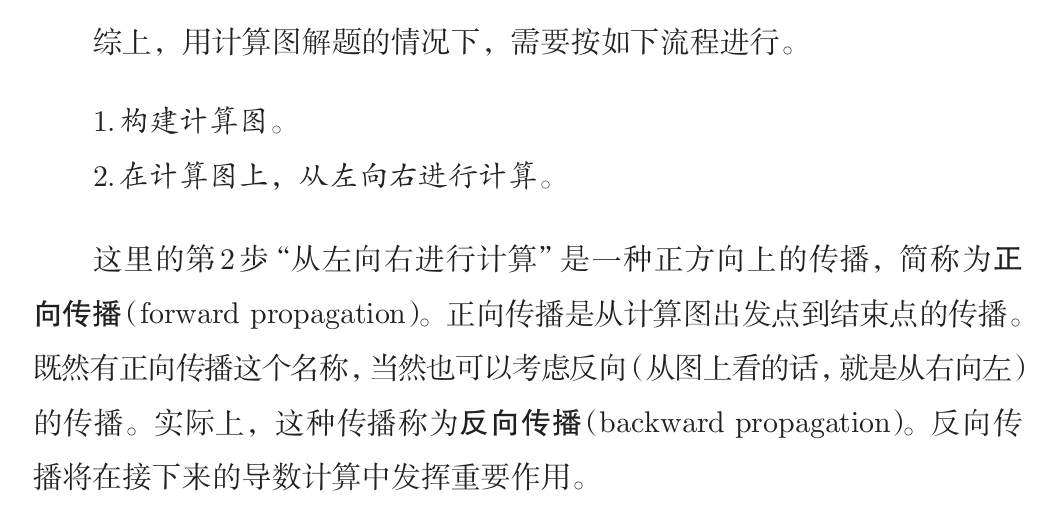
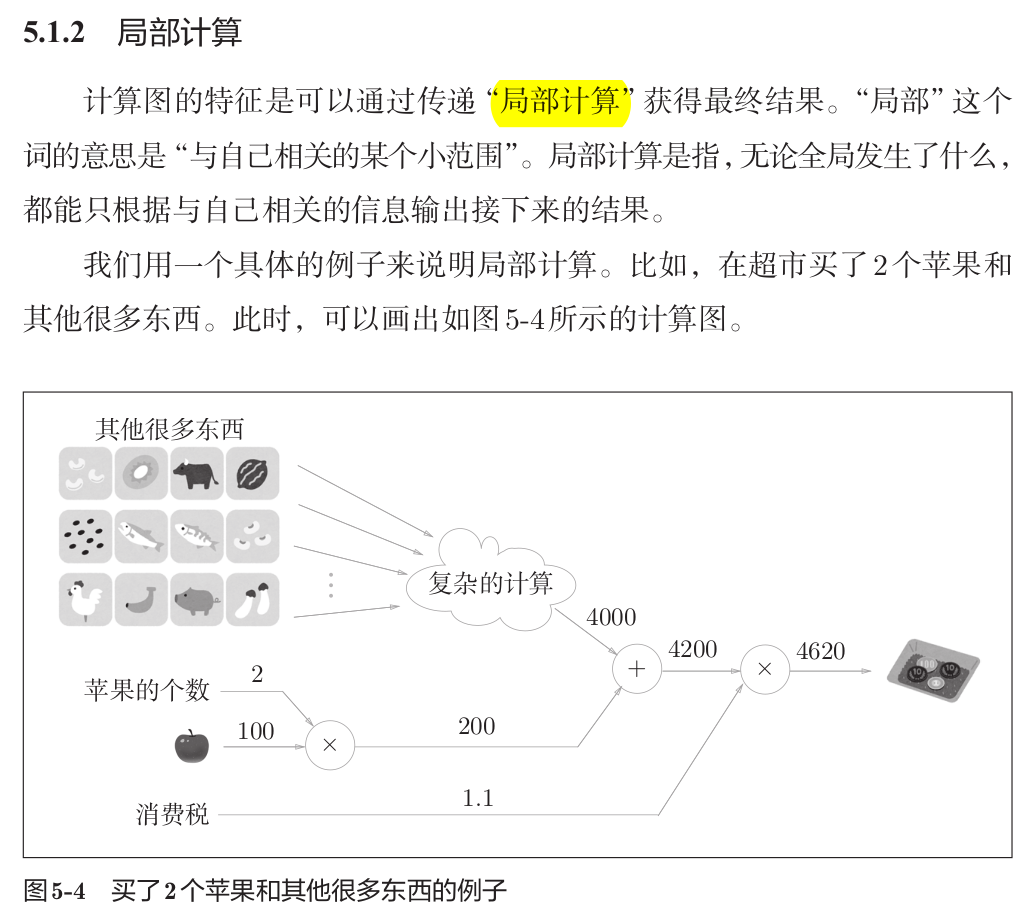

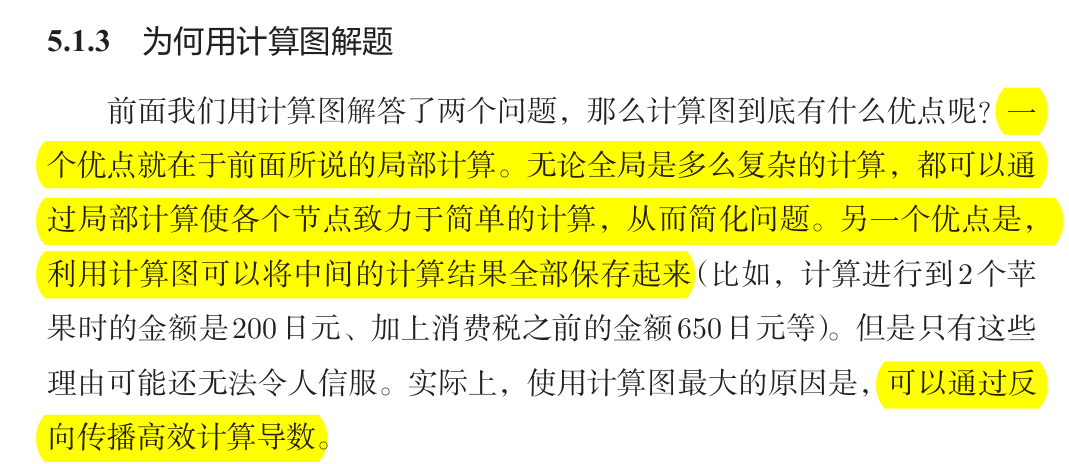

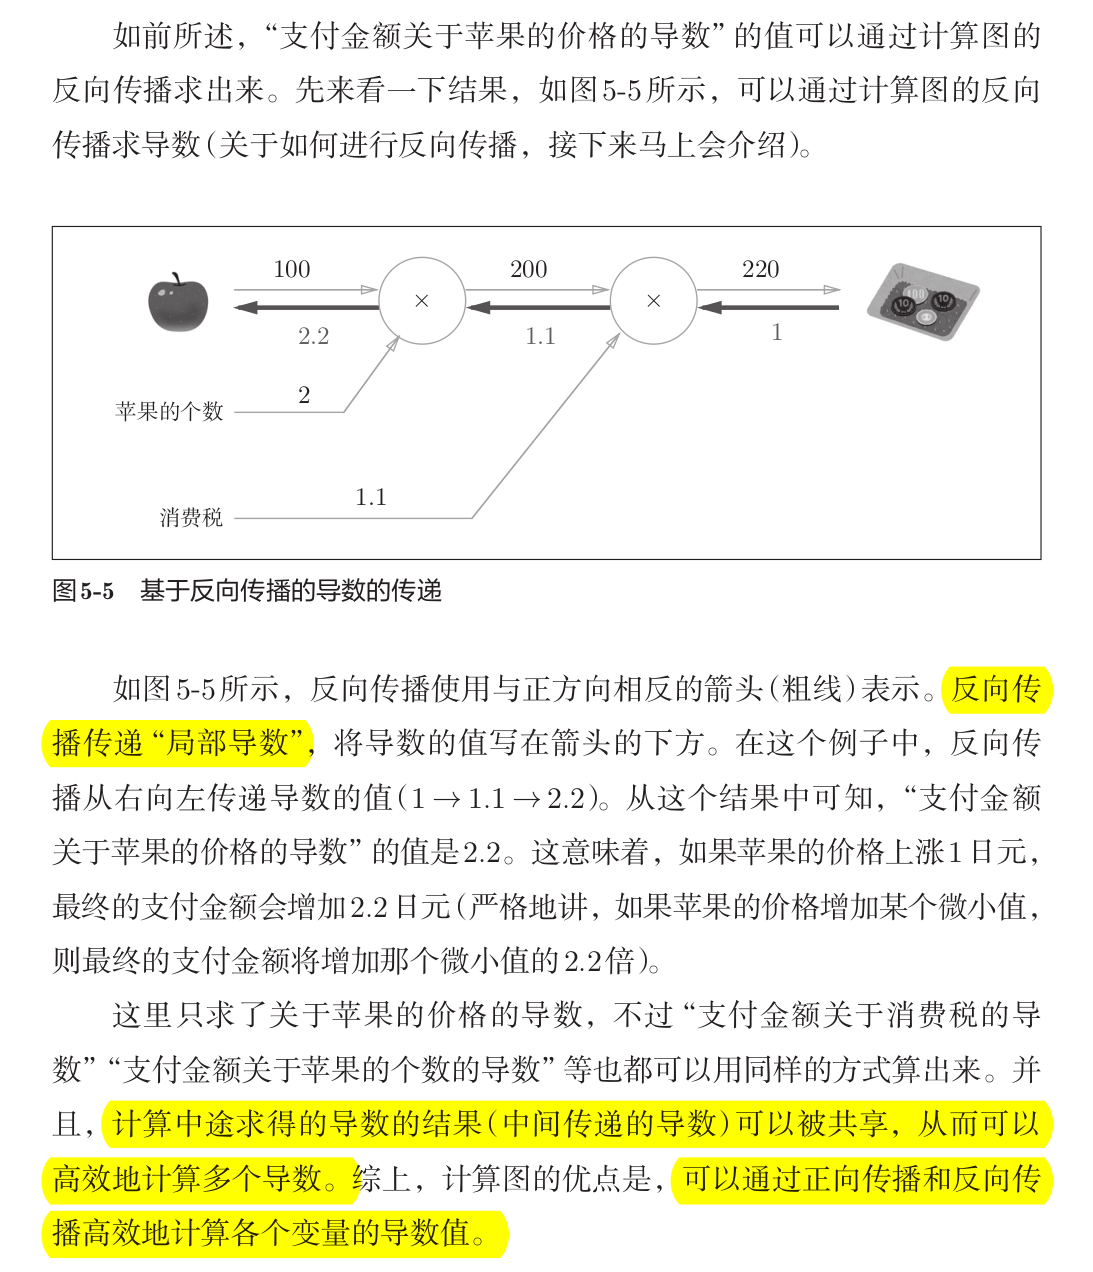

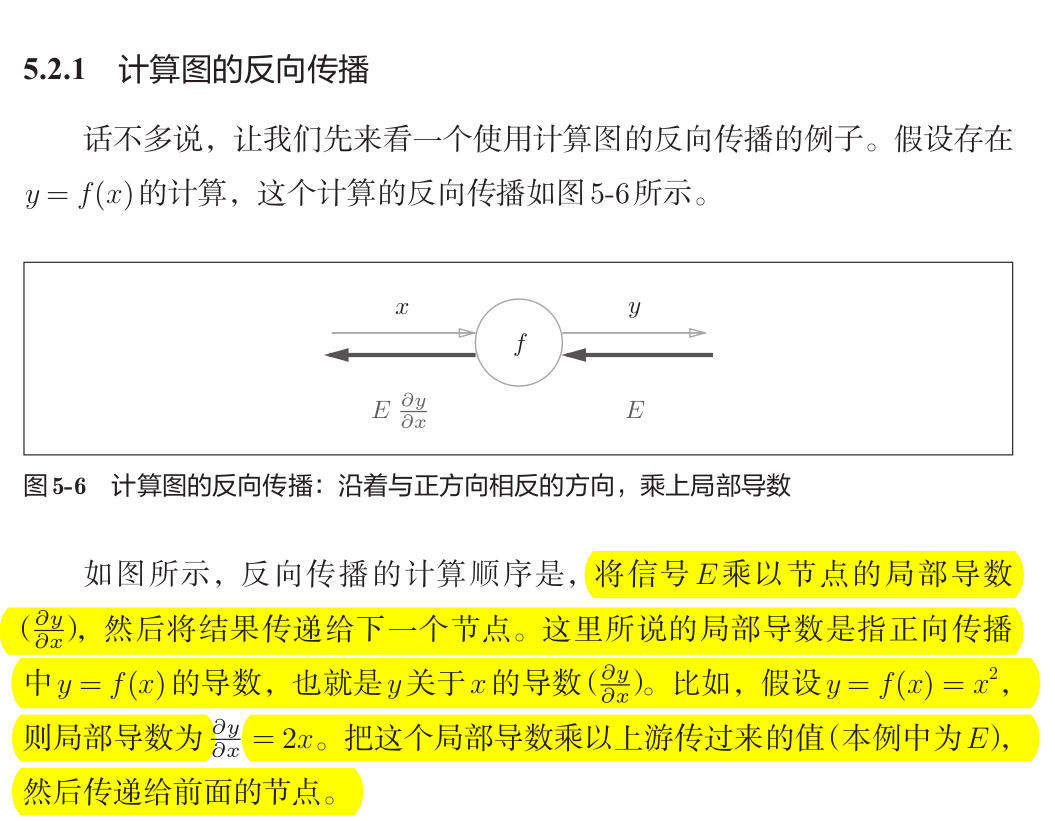

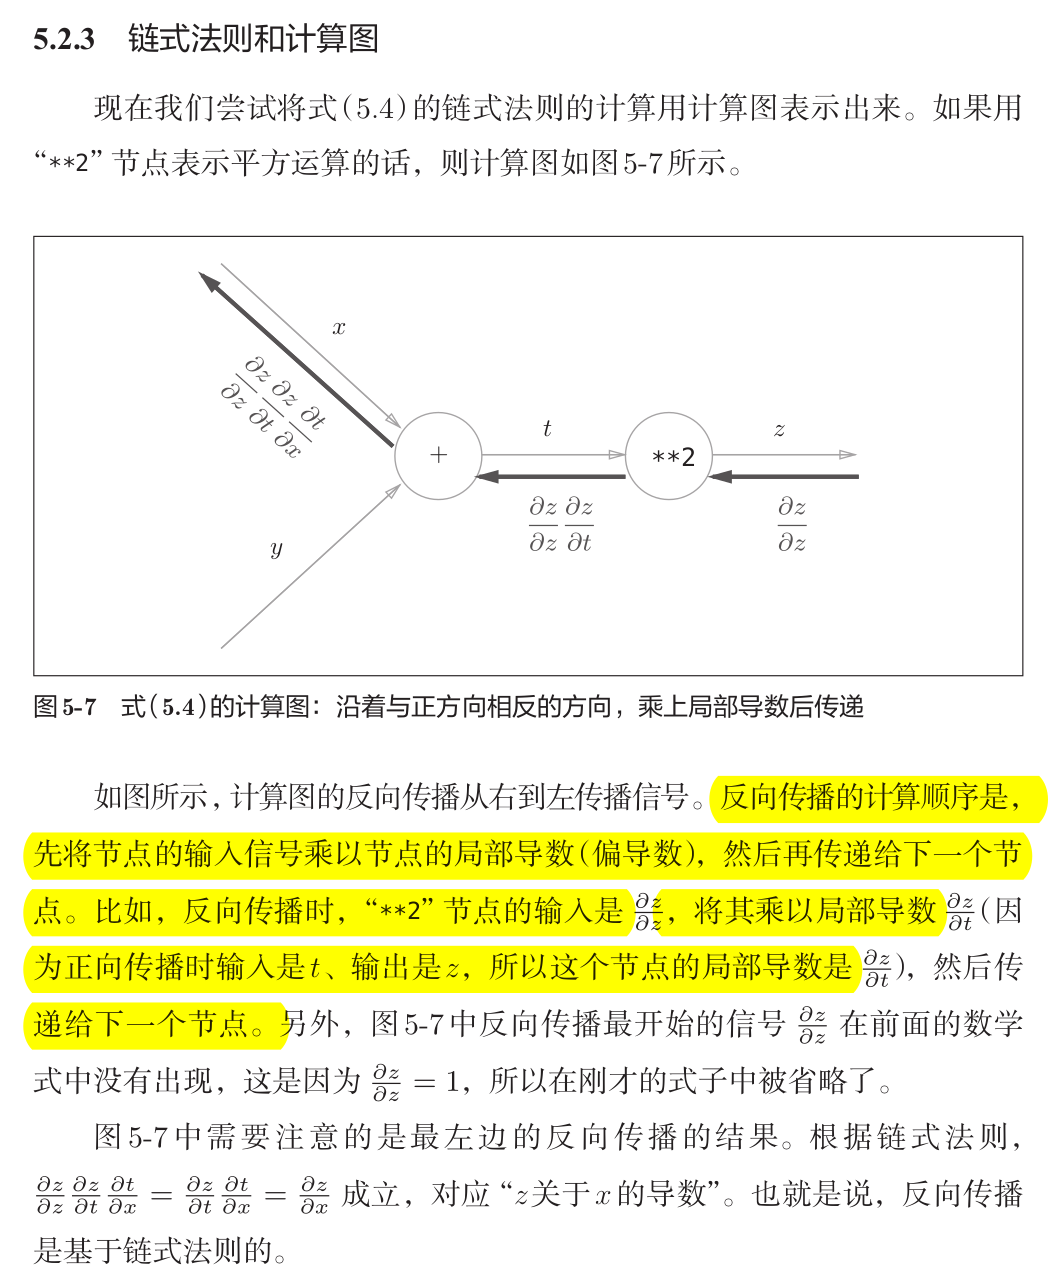

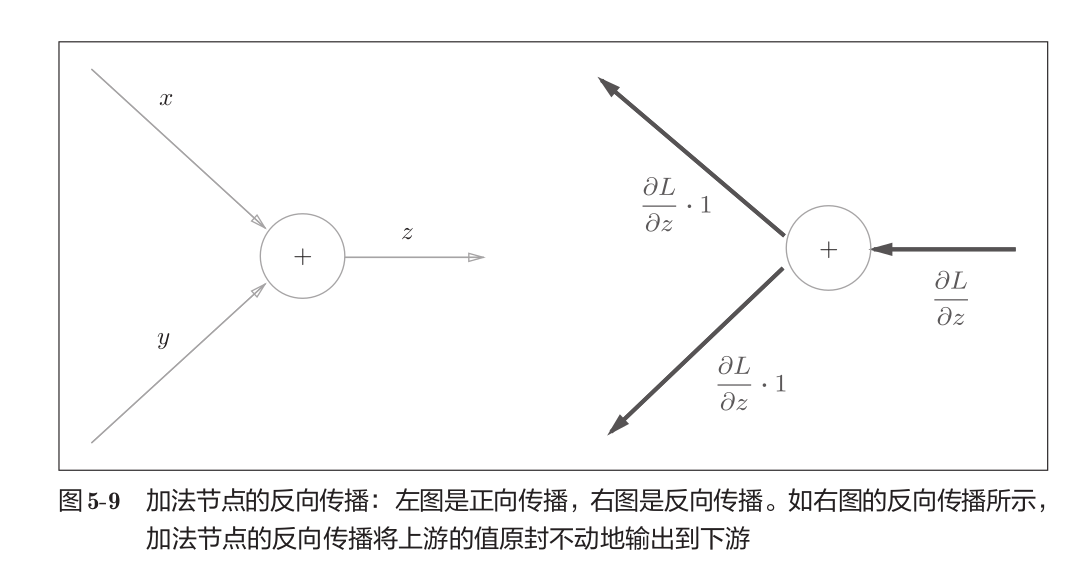
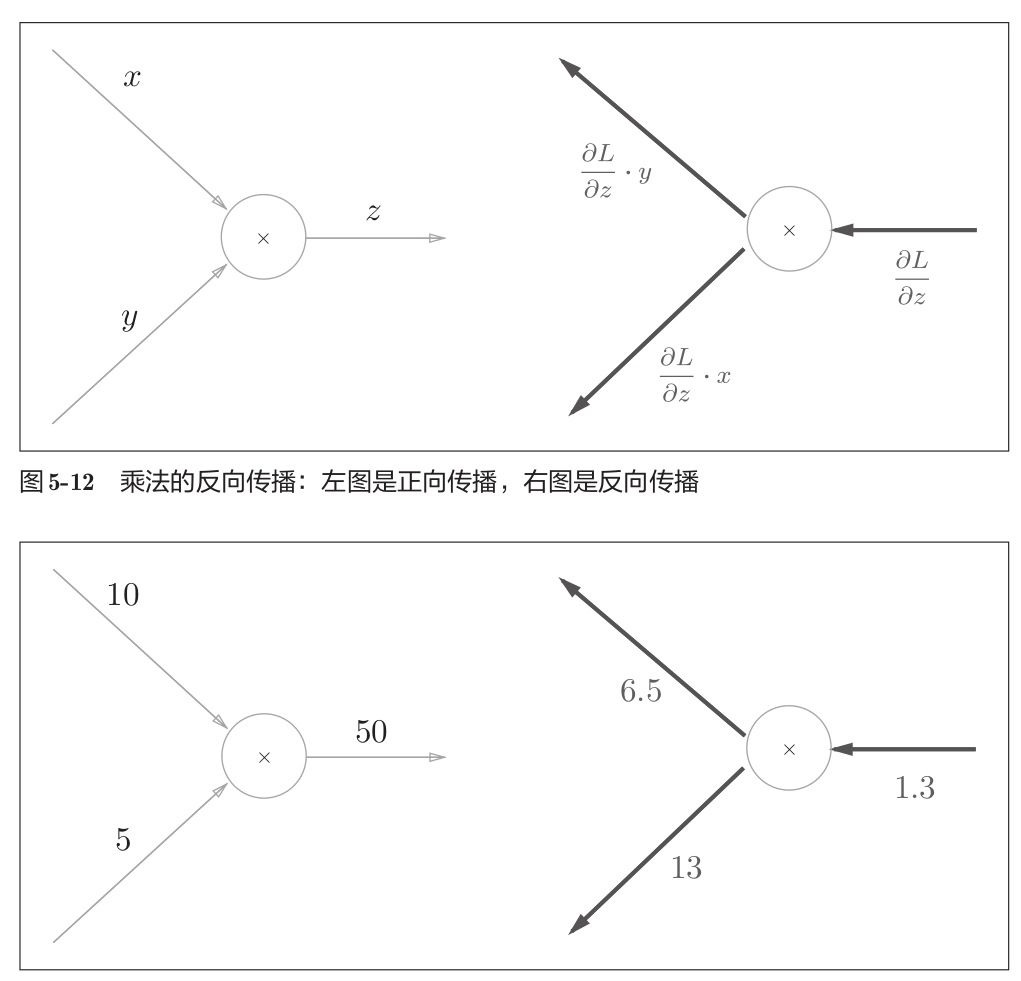

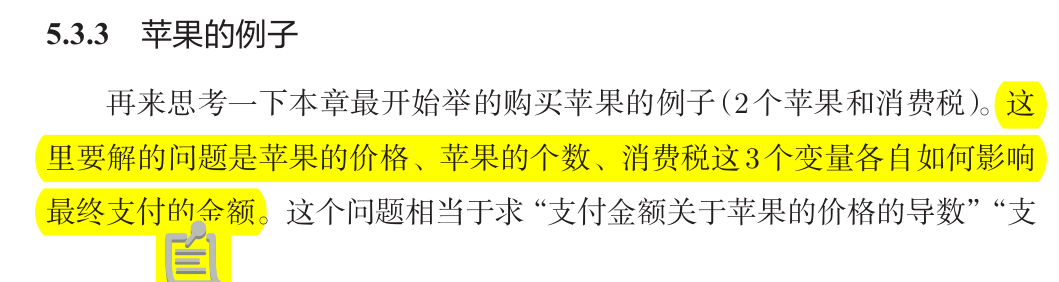
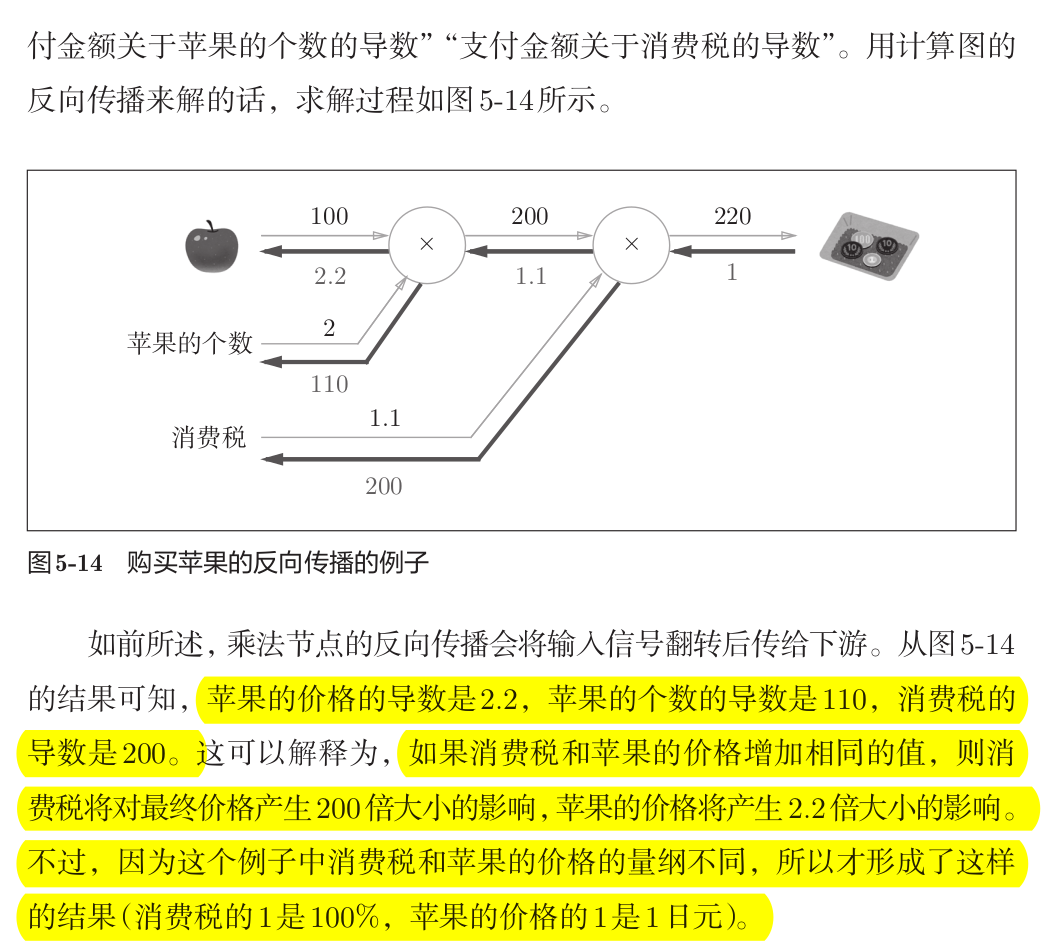

计算图就是计算计算图中参与的每个变量如何影响最终值的，换句话说就是最终的f分别对所有变量求偏导

In [139]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y): 
        self.x = x
        self.y = y
        out = x * y
        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

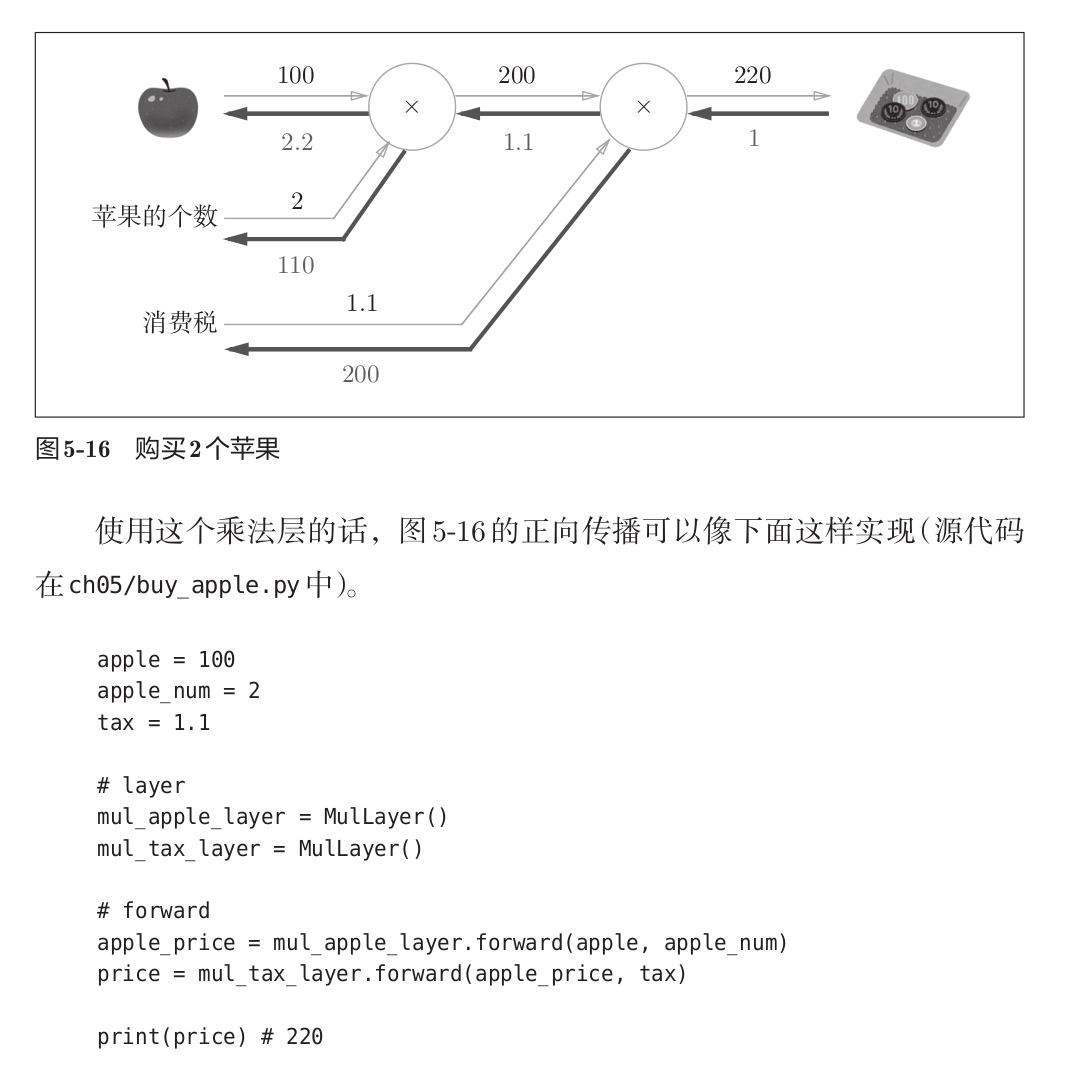

In [140]:
apple = 100
apple_num = 2
tax = 1.1
# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()
# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print(price) # 220

220.00000000000003


In [141]:
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print(dapple, dapple_num, dtax) # 2.2 110 200

2.2 110.00000000000001 200


In [142]:
class AddLayer:
    def __init__(self) -> None:
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y

        return x+y
    
    def backward(self, dout):
        dx = dout
        dy = dout

        return dx, dy
        

In [143]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1
# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()
# forward
apple_price = mul_apple_layer.forward(apple, apple_num) #(1)
orange_price = mul_orange_layer.forward(orange, orange_num) #(2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price) #(3)
price = mul_tax_layer.forward(all_price, tax) #(4)
# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice) #(4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price) #(3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price) #(2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price) #(1)
print(price) # 715
print(dapple_num, dapple, dorange, dorange_num, dtax) # 110 2.2 3.3 165 650

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


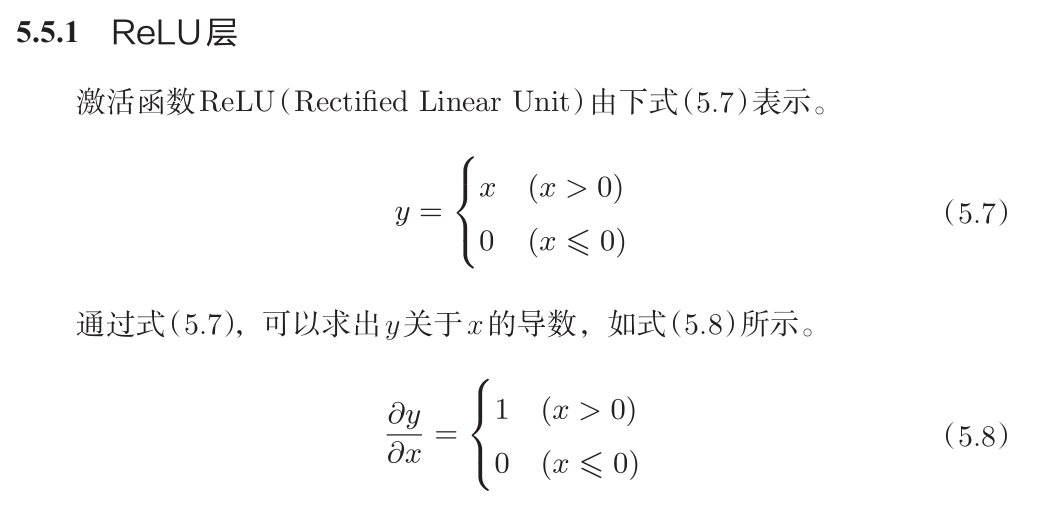

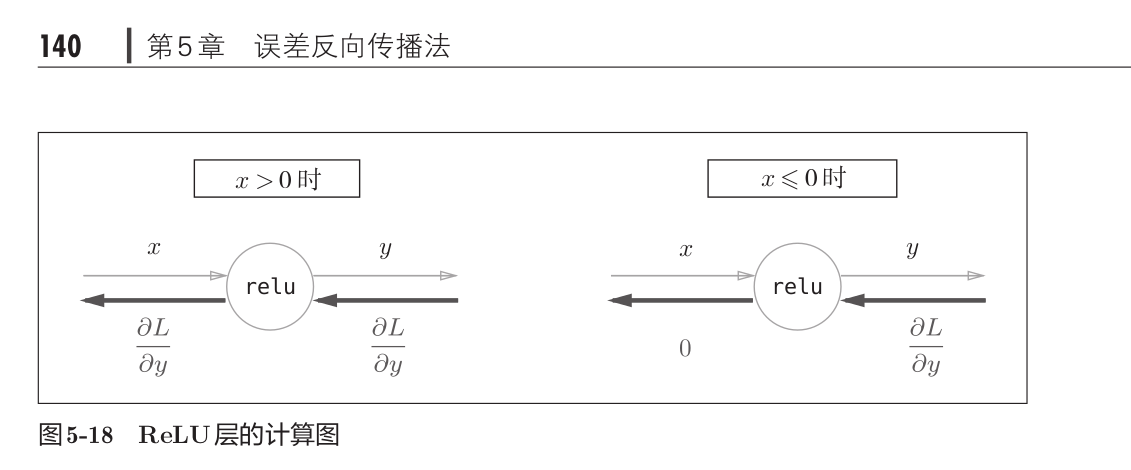

relu的实现还需要多看看

In [144]:
class Relu:
    def __init__(self):
        self.x = mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [145]:
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
mask = (x <= 0)
print(mask)
x[mask] = 0
print(x)

[[False  True]
 [ True False]]
[[1. 0.]
 [0. 3.]]


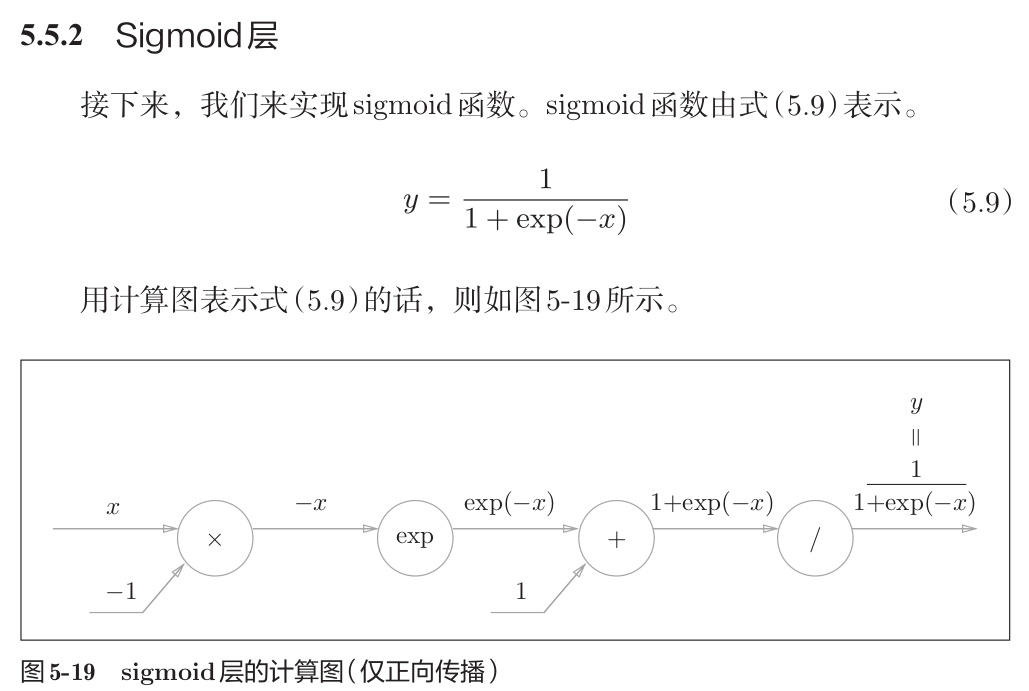

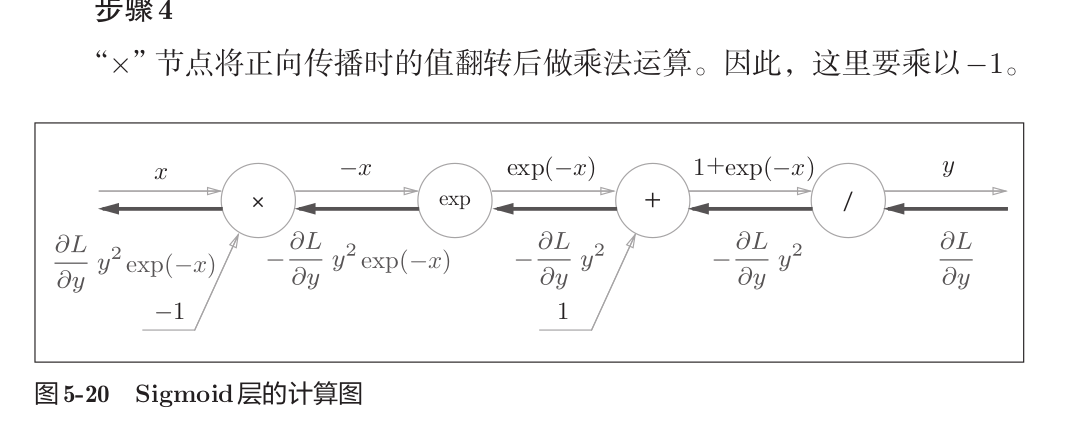

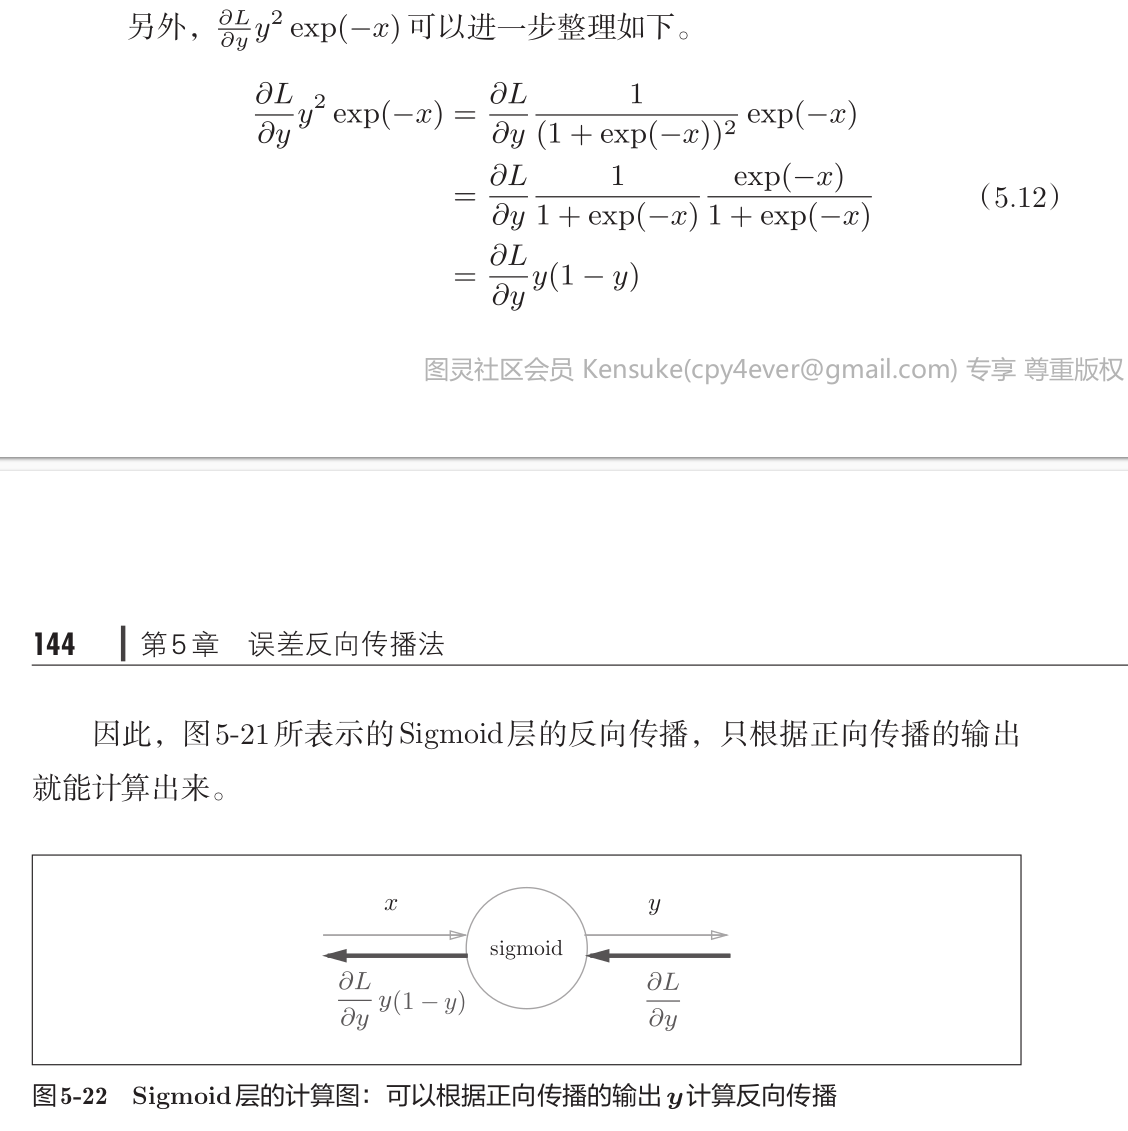

In [146]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self, dout):
        return dout * self.out * (1 - self.out)
    

In [147]:
X = np.random.rand(2)
# 输入
W = np.random.rand(2,3) # 权重
B = np.random.rand(3)

X.shape # (2,)
W.shape # (2, 3)
B.shape # (3,)

Y = np.dot(X, W) + B
Y.shape

(3,)

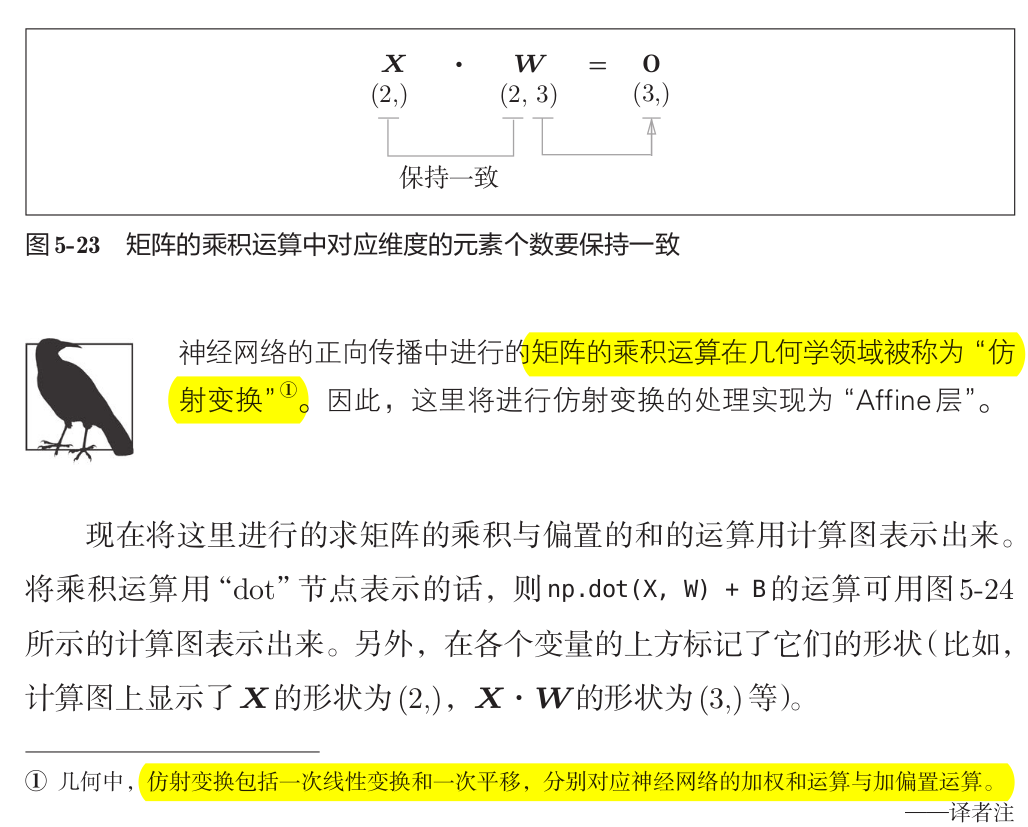

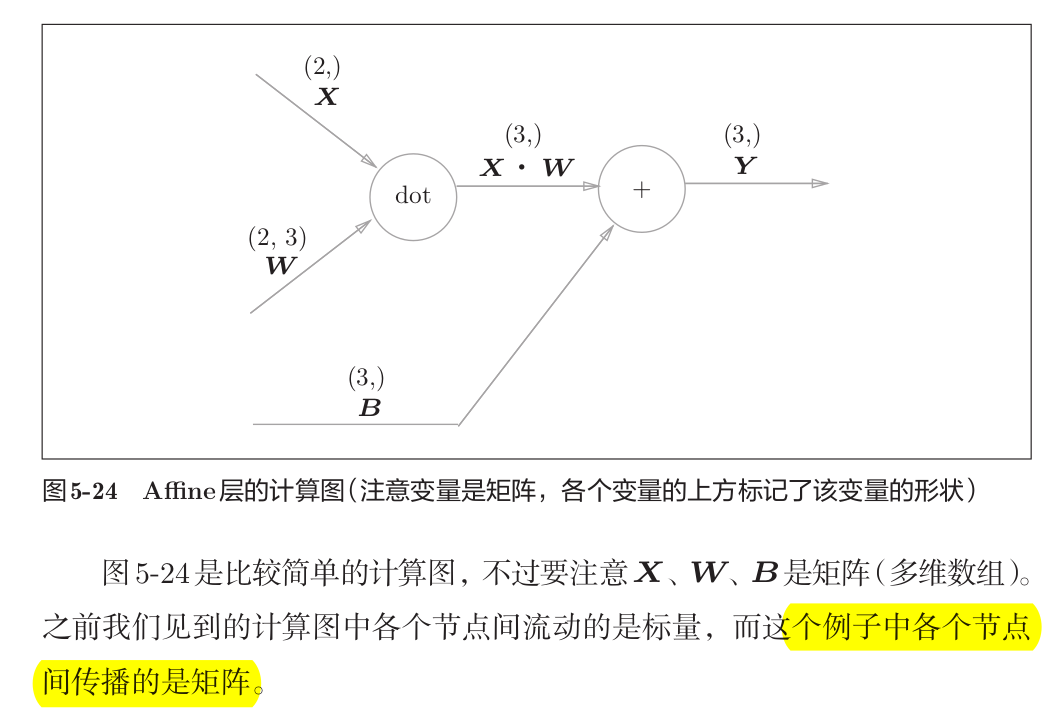

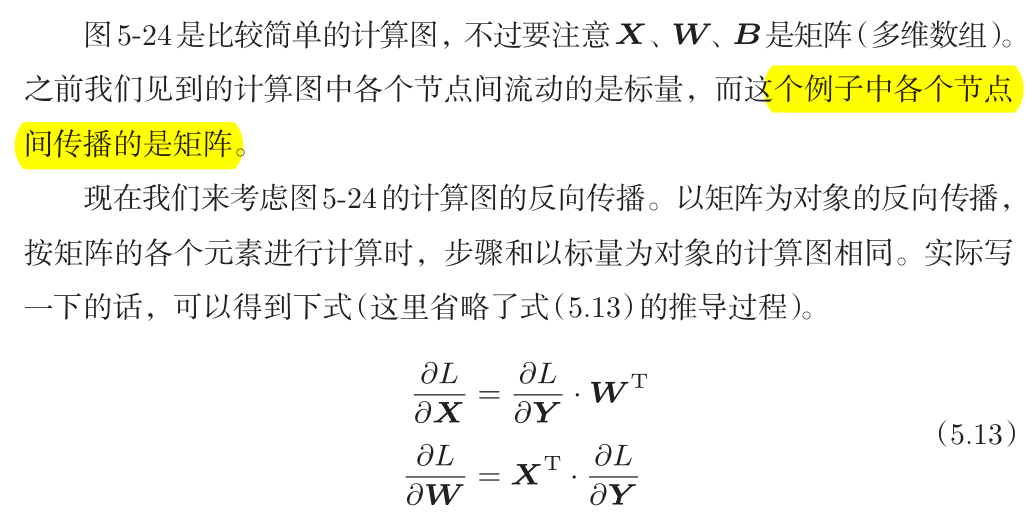

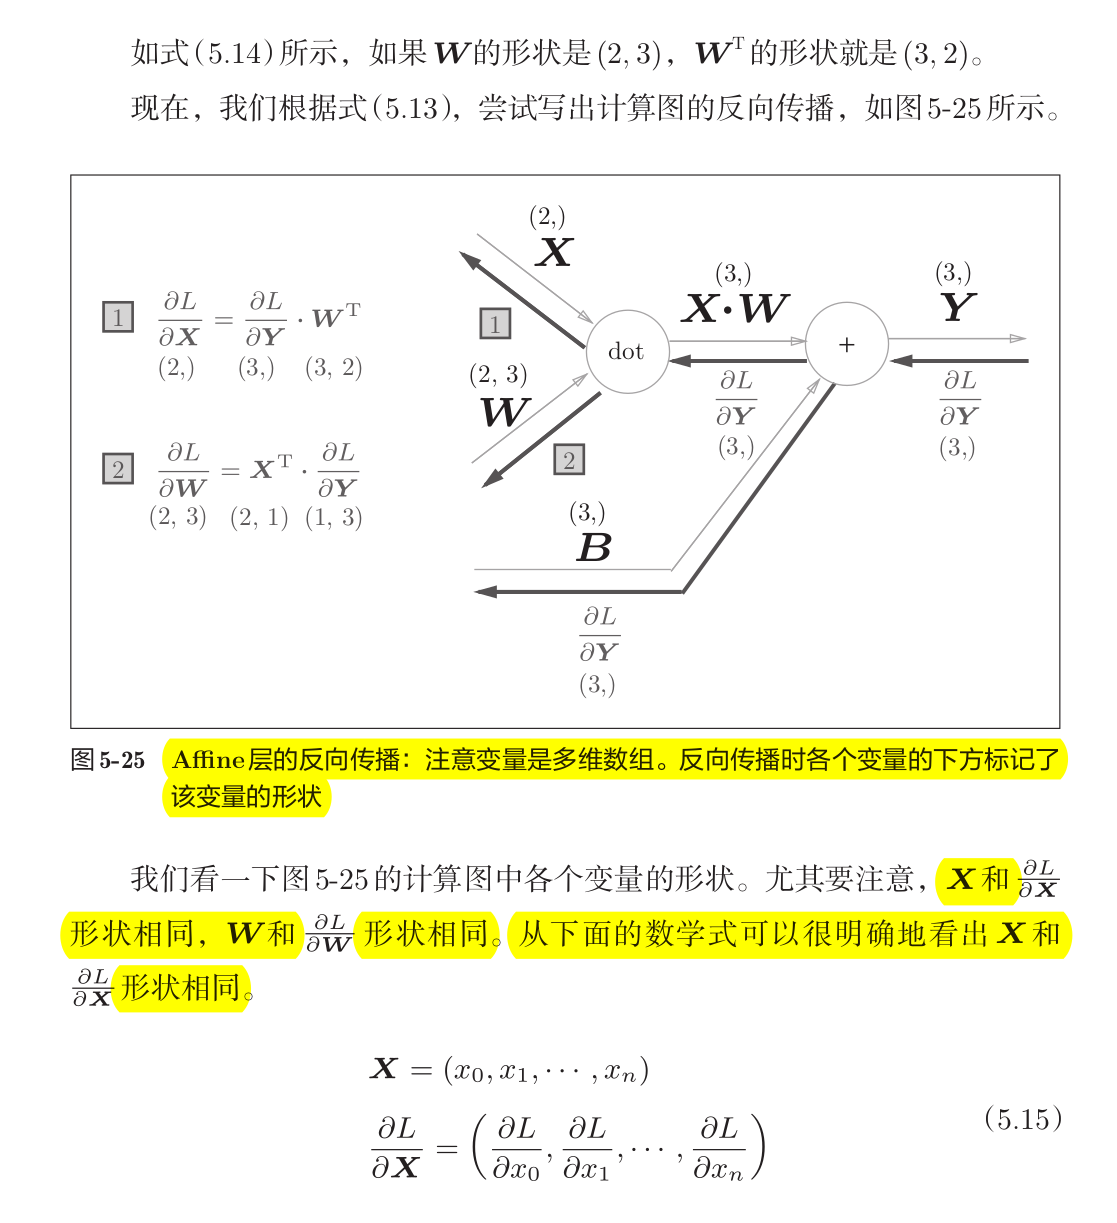

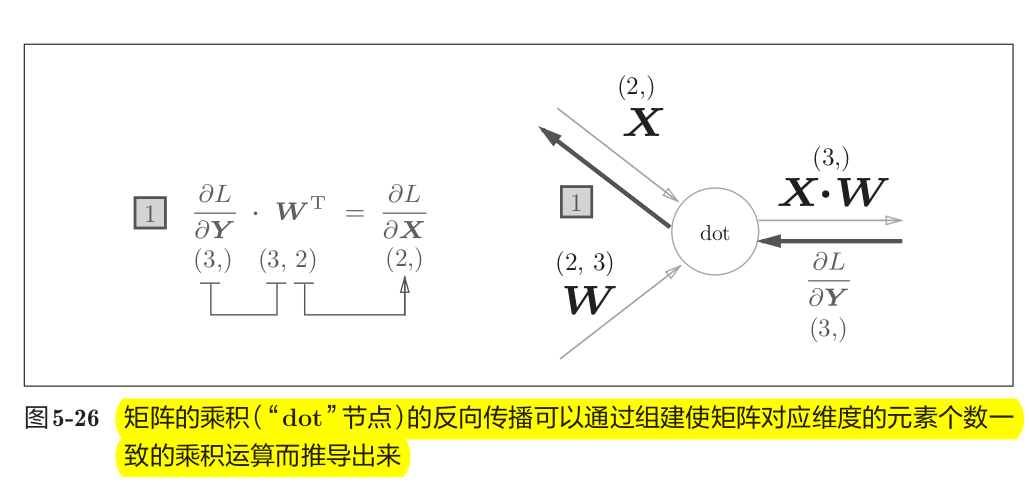

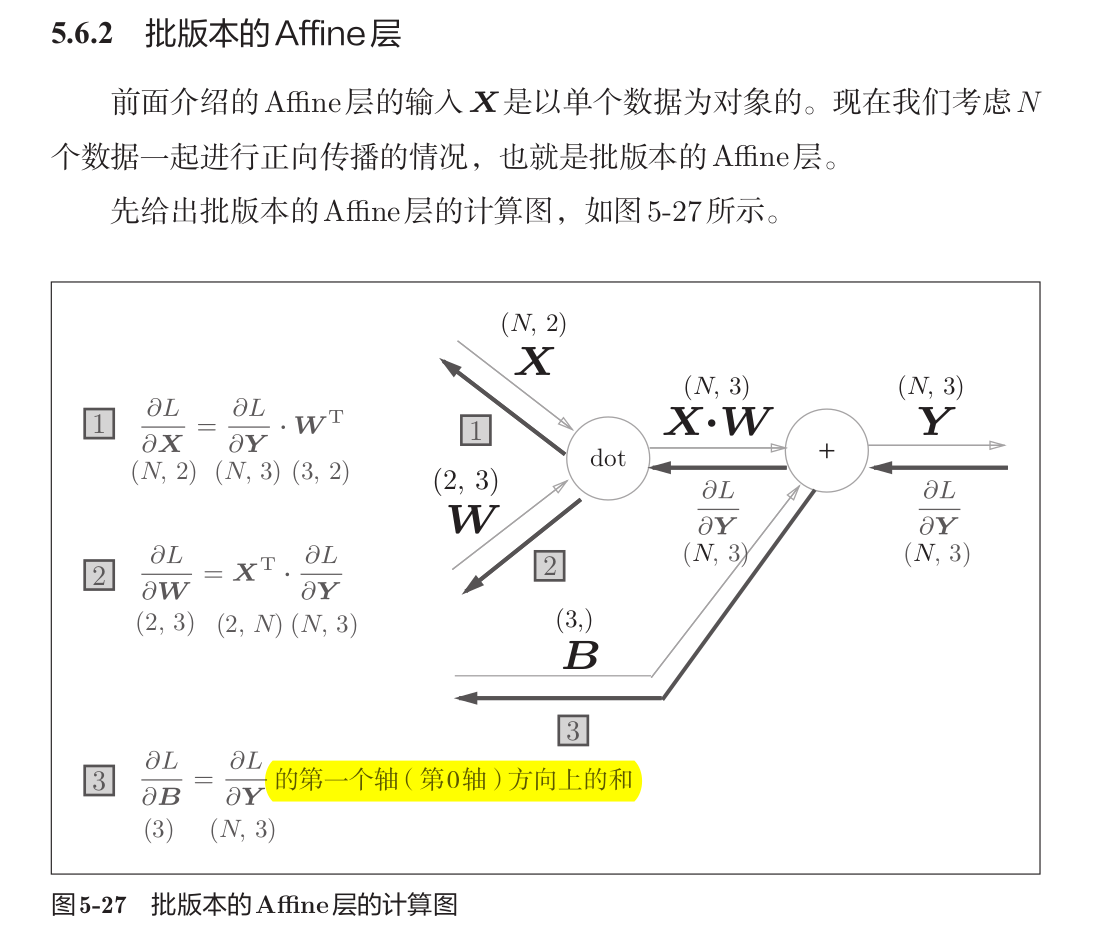

这一段没看懂

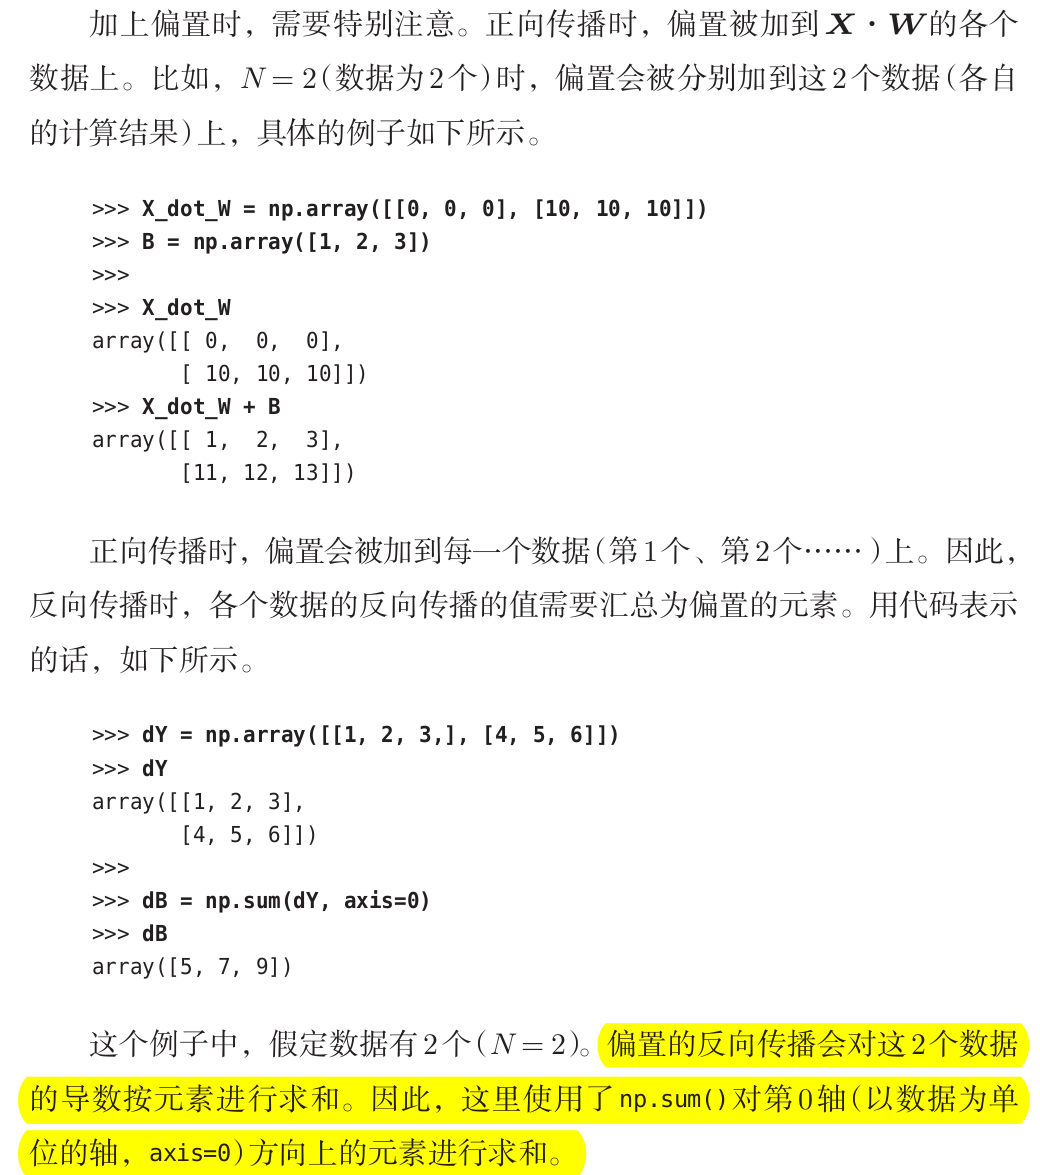

In [148]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        return np.dot(self.x, self.W) + self.b

    def backward(self, dout):
        dx = np.dot(dout, self.W.T) 
        self.dW = np.dot(self.x.T, dout)
        # db = dout # why it's wrong?
        self.db = np.sum(dout, axis=0)

        return dx

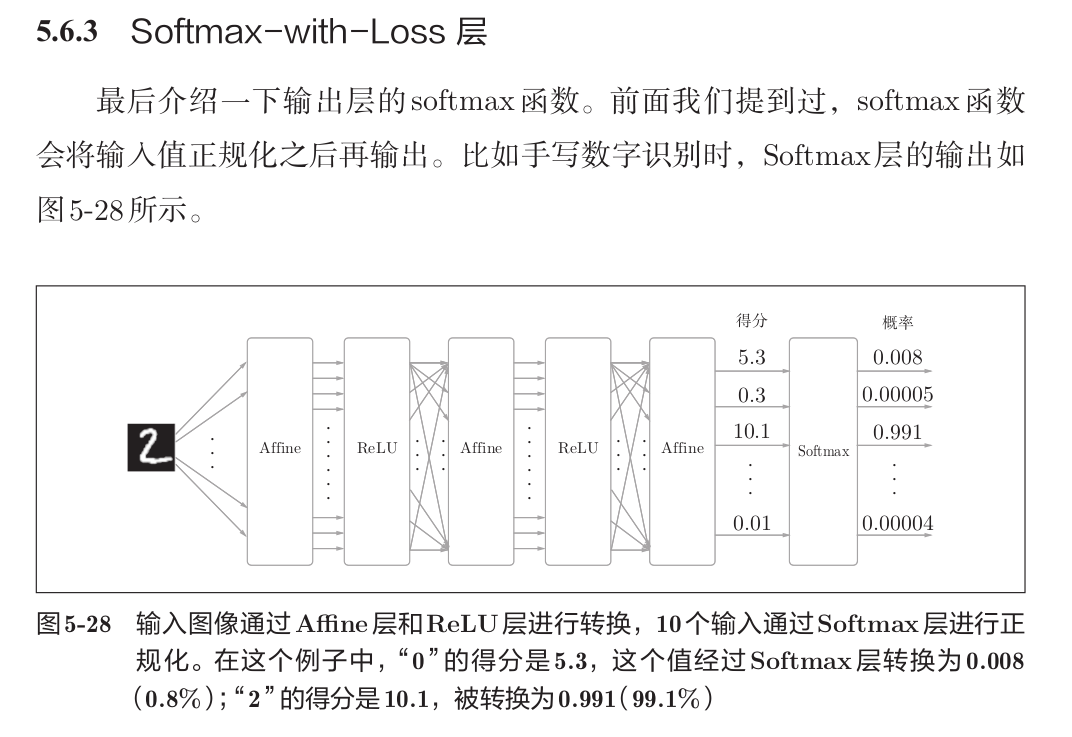

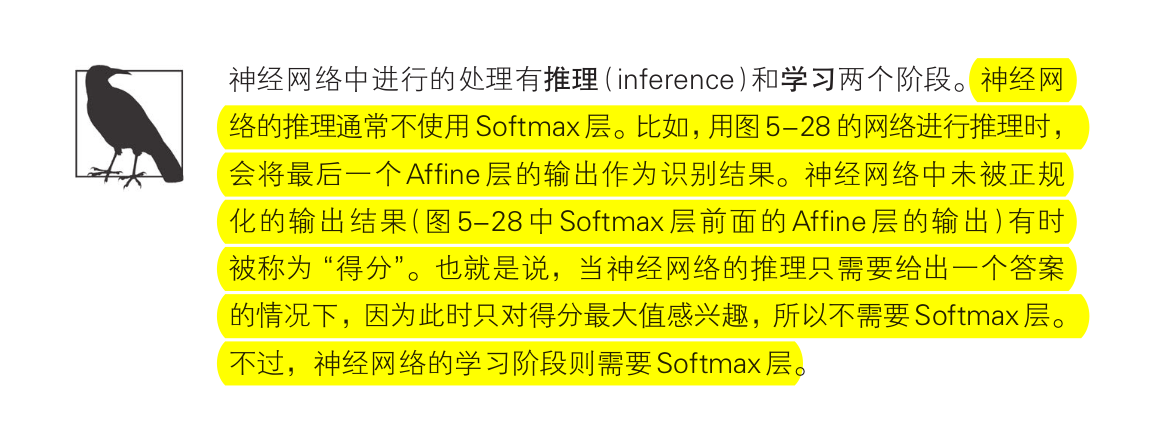

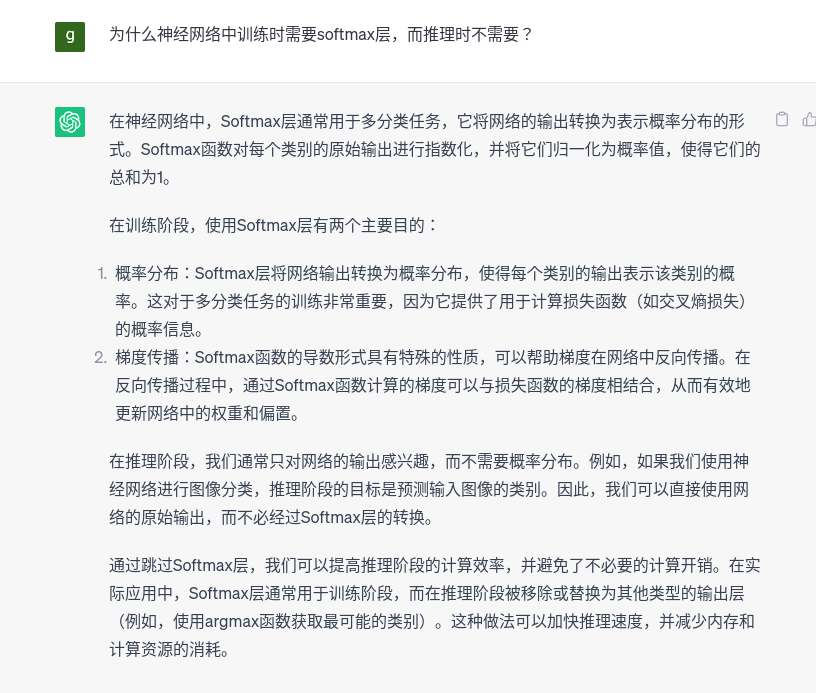

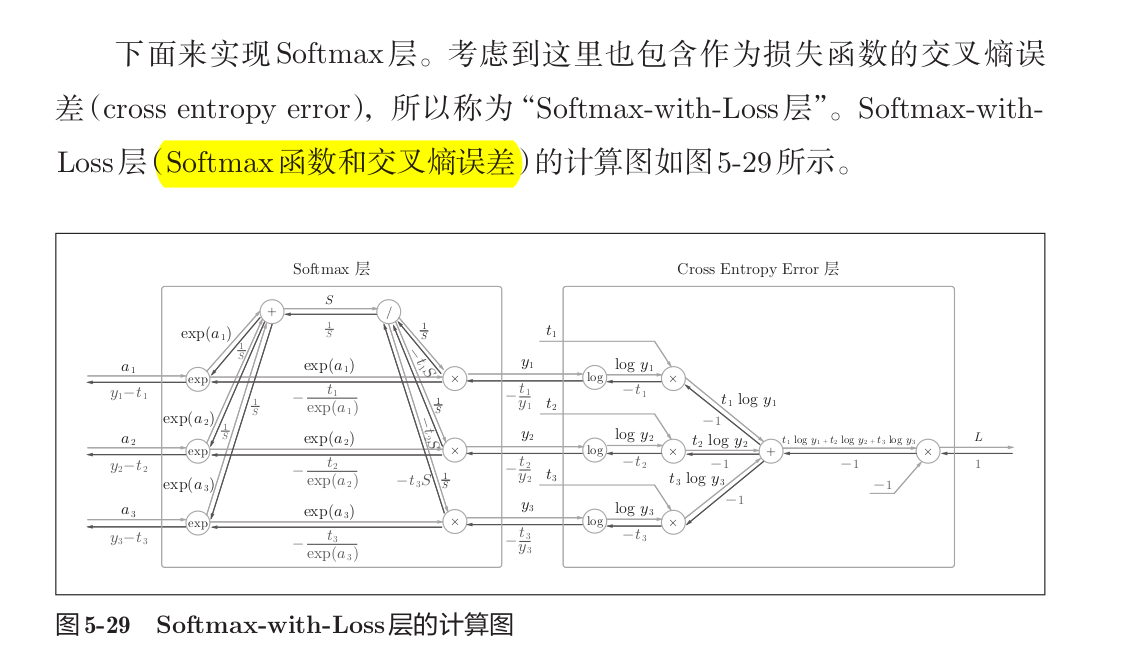

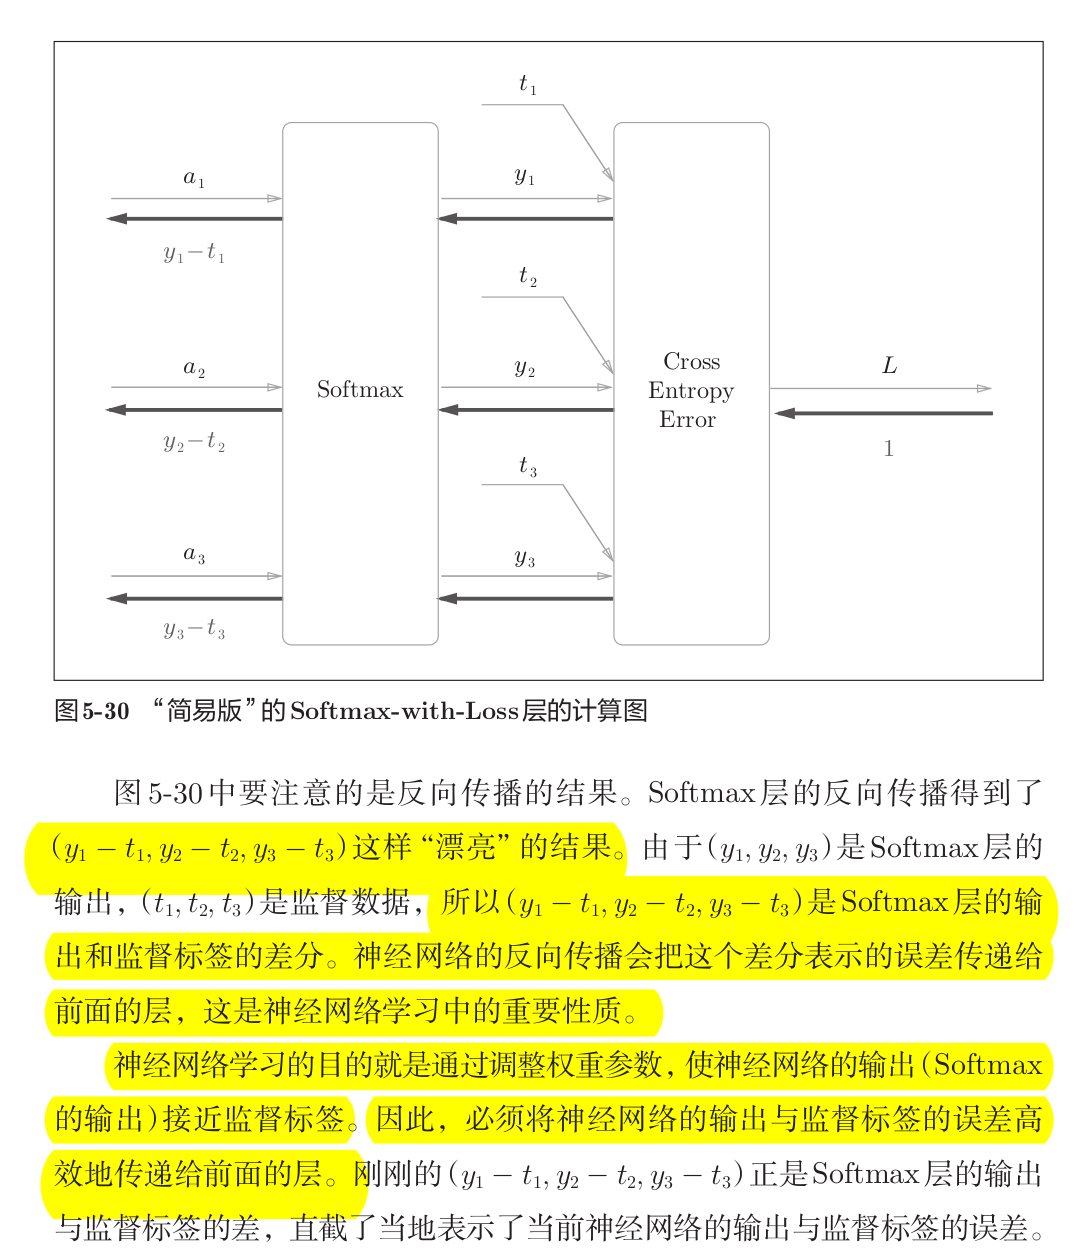

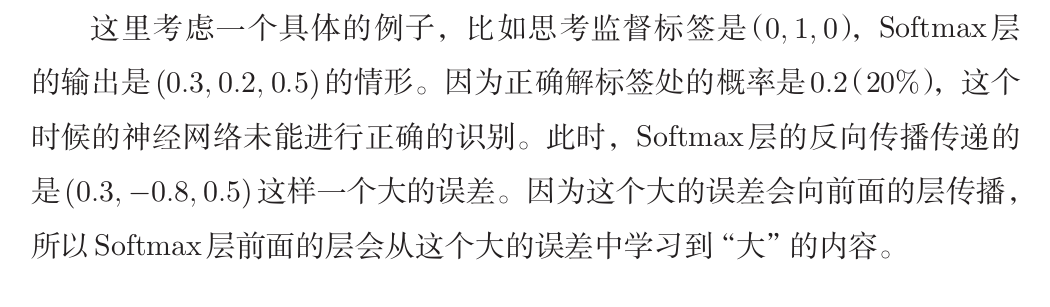
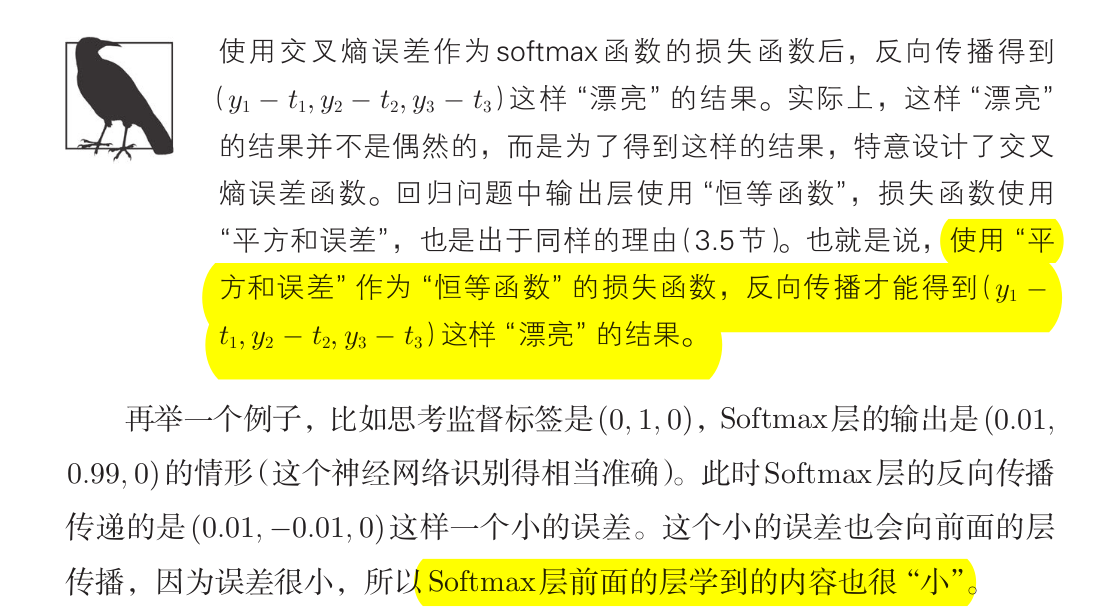

In [149]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

计算图的这些代码，要好好考虑一下各个函数的输入输出。

In [150]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.x = x
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y -self.t) / batch_size
        return dx 


In [151]:
def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

In [152]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        # tmp = x.copy()
        # for layer in self.layers.values():
        #     tmp = layer.forward(tmp)
        # return tmp
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    
    def loss(self, x, t):
        y = self.predict(x)
        # return cross_entropy_error(y, t) # layes not contains softmax layer
        return self.lastLayer.forward(y, t)

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t): 
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
        
        # 设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim !=1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [153]:
mnist = fetch_openml('mnist_784')
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, shuffle=False)

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

def _flatten(x):
    return x.reshape(28, 28)

def _normalize(x):
    return x / 255.0

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    (x_train, t_train), (x_test, t_test) = (X_train.to_numpy(), y_train.to_numpy()), (X_test.to_numpy(), y_test.to_numpy())
    
    t_train = t_train.astype(np.int32)
    t_test= t_test.astype(np.int32)
    if normalize:
        x_train = _normalize(x_train)
        x_test = _normalize(x_test)

    if not flatten:
        x_train = _flatten(x_train)
        x_test = _flatten(x_test)

    if one_hot_label:
        t_train = _change_one_hot_label(t_train)
        t_test = _change_one_hot_label(t_test)

    return (x_train, t_train), (x_test, t_test)

/home/frog/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


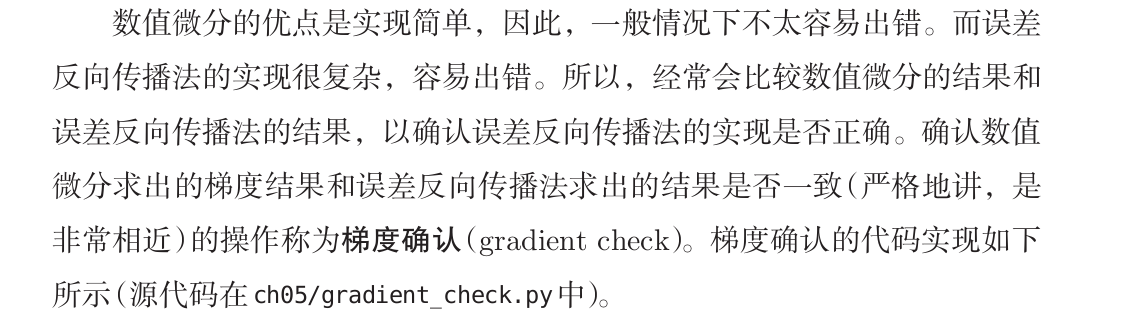

In [154]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
x_batch = x_train[:3]
t_batch = t_train[:3]
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)
# 求各个权重的绝对误差的平均值
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

In [155]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

In [157]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 通过误差反向传播法求梯度
    grad = network.gradient(x_batch, t_batch)
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.13453333333333334 0.132
0.9028833333333334 0.9071
0.9215833333333333 0.9239
0.9347 0.9357
0.9447333333333333 0.944
0.95105 0.9483
0.9557 0.9532
0.9592166666666667 0.955
0.96295 0.9575
0.9667166666666667 0.9604
0.9694 0.9623
0.9716166666666667 0.9646
0.9730666666666666 0.9663
0.97525 0.9675
0.9759666666666666 0.9685
0.9775166666666667 0.9689
0.9790166666666666 0.9701
